In [3]:
from detectron2.config import get_cfg
from detectron2.modeling import build_model

In [4]:
cfg = get_cfg()
with open("pretrained_models/pointrend_semantic_R_101_FPN_1x_cityscapes.yaml", "w") as f:
    f.write(cfg.dump())

model = build_model(cfg)

In [3]:
from torchvision.models.segmentation import deeplabv3_resnet101, deeplabv3_mobilenet_v3_large, deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet101_Weights, DeepLabV3_MobileNet_V3_Large_Weights, DeepLabV3_ResNet50_Weights, DeepLabHead


model_weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=model_weights)
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [3]:
from get_model import load_model
model = load_model('resnet101')
print(model)

DeepLabV3, resnet101 backbone
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=

In [1]:
import torch
from get_model import PointRendDeepLabV3
# from torchvision.models.segmentation import deeplabv3_resnet101

# Instantiate the model
model = PointRendDeepLabV3(backbone='resnet101', num_classes=21)
# model2 = deeplabv3_resnet101(weights='DEFAULT')

# print(model2.backbone)
# print(model)


# Test with dummy input
dummy_input = torch.randn(2, 3, 512, 512)
output = model(dummy_input)
print(output.shape)

/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([2, 2048, 1000])
torch.Size([2, 21, 1000])
torch.Size([2, 2069, 1000])
torch.Size([1000, 2])
torch.Size([2, 1000, 21])


RuntimeError: Index tensor must have the same number of dimensions as self tensor

In [1]:
from torchvision.models.segmentation import deeplabv3_resnet101
from test_pointrend import PointRend
import torch

deeplabv3 = deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21, aux_loss=True)
deeplabv3.classifier = PointRend(input_channels=2048, num_classes=21)

def create_synthetic_test():
    # Create a synthetic RGB image and corresponding label
    image = torch.rand(1, 3, 256, 256)  # Batch size 1, 3 color channels, 256x256 pixels
    target = torch.randint(0, 21, (1, 256, 256))  # Random classes from 0 to 20

    return image, target

image, target = create_synthetic_test()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplabv3 = deeplabv3.to(device)
image = image.to(device)

# Set the model to evaluation mode
deeplabv3.eval()

# Forward pass, assuming correct output keys and structures
with torch.no_grad():
    features = deeplabv3.backbone(image)  # Extract features using the backbone
    if 'aux' in features:  # If the model has an auxiliary output, we use it for fine-grained features
        fine_grained_features = features['aux']
    else:
        fine_grained_features = features  # Otherwise, use the main output features
        
    # Assuming 'out' contains the coarse prediction (modify according to your model's specifics)
    coarse_predictions = deeplabv3.classifier.mlp(features['out'])  # Directly use MLP if integrated within PointRend
    output = deeplabv3.classifier({'out': coarse_predictions, 'aux': fine_grained_features})
    print("Output shape:", output.shape)

/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Given groups=1, weight of size [256, 256, 1, 1], expected input[1, 2048, 32, 32] to have 256 channels, but got 2048 channels instead

/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PointRend(
  (backbone): SmallDeepLab(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

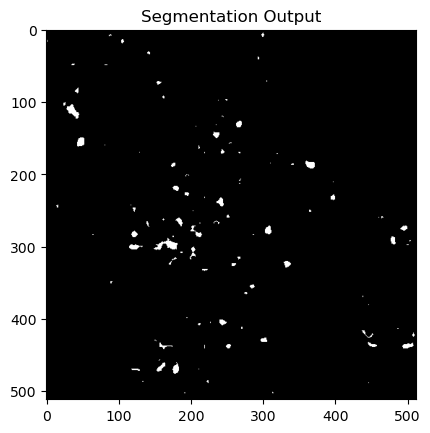

In [5]:
from test_pointrend import deeplabv3, PointHead, PointRend
import torch
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)  

# x = torch.randn(3, 3, 256, 512)

# Path to the image
image_path1 = 'data/segmentation_dataset/subfolder_1/images/csr0129a_front_view.png'
image_path2 = 'data/segmentation_dataset/subfolder_1/images/csr0087a_front_view.png'

# Load and preprocess the image
im1 = load_image(image_path1)
im2 = load_image(image_path2)

x = torch.cat([im1, im2], dim=0)

net = PointRend(deeplabv3(False), PointHead(in_c=533))
print(net)
result = net(x)

pred = F.interpolate(result["coarse"], x.shape[-2:], mode="bilinear", align_corners=True)
preds = pred.argmax(1)

output_mask = (preds[0] == 16)

plt.imshow(output_mask, cmap='gray')
plt.title("Segmentation Output")
plt.show()